# Support Vector Machine (SVM) with Pegasos

Some important namespaces are loaded.

In [1]:
import numpy as np #numerical operation
import pandas as pd #tabular data
from tqdm import tqdm #progress bars
import matplotlib.pyplot as plt #figures
from sklearn.linear_model import LinearRegression #linear regression benchmark
import sys #System-specific parameters and functions

The custum modules, consisting of among others the Pegasos algorithm, are imported. 
Therefore, a relative path is appended to the system path.

In [2]:
sys.path.insert(1, 'Modules/')
from Evaluation_Metric import Metric_regression
from Cross_validation import preparation_cross_validation
golden_section_search = __import__('20220716_Golden_Section_Search').golden_section_search
from Primal_Pegasos import Pegasos_regression
Pegasos_kernel = __import__('Kernel_Pegasos').Pegasos_kernel_regression
Kernel_p = __import__('Kernel_Pegasos').Kernel_polynomial   
Kernel_rbf = __import__('Kernel_Pegasos').RBF   

The **boston house prices** dataset is imported. 
The dataset is commonly used for comparison regression algorithm.
The data was originally published by Harrison, D. and Rubinfeld, D.L. `Hedonic prices and the demand for clean air', J. Environ. Economics & Management, vol.5, 81-102, 1978.

http://lib.stat.cmu.edu/datasets/boston (accessed on 26th July 2022)

In [3]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']


Non numeric values are removed from this dataset. 
Each row, containing NaN, is removed ensuring only numeric values.

In [4]:
X_nan = np.isnan(data)
X_nan = X_nan.sum(axis=1)
X_no_nan = X_nan == 0
X = data[X_no_nan,:]
y = target[X_no_nan]

The feature matrix is centered around 0 with a standard deviation of 1. 

In [5]:
X = X - X.mean(axis=0)
X = X / X.var(axis=0)**0.5

The dataset is randomly splitted in trainings and testing data. 
The algorthm is trained and the hyperparameter are adjusted based on the trainings data. 
The final performance evaluation is done with the test data.

In [6]:
np.random.seed(42)
n = X.shape[0]
split_fraction = 0.8
n_random = np.random.permutation(n)
n_train = n_random[:int(n*split_fraction)]
n_test = n_random[int(n*split_fraction):]

X_train = X[n_train,:]
y_train = y[n_train]

X_test = X[n_test,:]
y_test =  y[n_test]

The trainings data set is splitted into $n$ bags. 
For randomization the modul numpy is applied. 
The optimal regularisation parameter $\lambda$ is searched such that the validation error is minimized. 
Therefore, the models are fitted on $n - 1$ bags and the performance is evaluated on $1$ bag.

In [7]:
n_bags = 10
np.random.seed(42)
bags_list = preparation_cross_validation(X_train, y_train, n_bags)

The test error is approximated with the validaiton error. 
Therefore, the function *MSE_l* fits the linear Pegasos models to the trainings data and return the validation error.

In [8]:
epoch_max_diagram = 100
def MSE_l (l, Pegasos_regression, epoch_max, epsilon, X_train, y_train, X_val, y_val):
    Pegasos = Pegasos_regression(regularization=l,
                                 epoch_max=epoch_max,
                                 epsilon=epsilon,
                                 verbose=False)
    Pegasos.fit(X_train, y_train)
    MSE_ = Pegasos.MSE(X_val, y_val)
    return (MSE_) 

The error on the validation set is unimodal with exactly one minimum. 
The $n$ cross validation sets are plotted as a function of $\lambda$.

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [15:56<00:00, 95.68s/it]


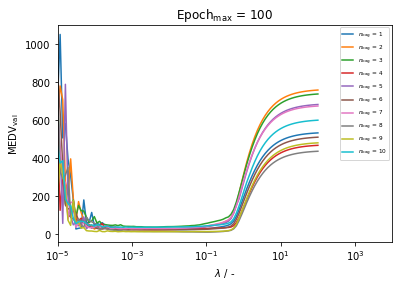

In [9]:
legend_list = ['$n\mathrm{_{bag}}$ = ' + str(i+1) for i in range(n_bags)]
l_array = np.logspace(-5, 2, 100)
for n_val in tqdm(range (n_bags)):
    X_train_ = []
    y_train_ = []
    X_val_ = np.array(bags_list[n_val].x)
    y_val_ =  np.array(bags_list[n_val].y)
    for n in range (n_bags):
        if n_val != n:
            X_train_ += bags_list[n].x
            y_train_ += bags_list[n].y
    X_train_ = np.array(X_train_)
    y_train_ = np.array(y_train_)

    MSE_min = lambda l: MSE_l(l, 
                              Pegasos_regression=Pegasos_regression, 
                              epoch_max=epoch_max_diagram, 
                              epsilon=1E-8, 
                              X_train=X_train_, 
                              y_train=y_train_, 
                              X_val=X_val_, 
                              y_val=y_val_)
    MSE_min_vec = np.vectorize(MSE_min)
    plt.plot(l_array, MSE_min_vec(l_array))

plt.title('Epoch$\mathrm{_{max}}$ = ' + '{:.0f}'.format(epoch_max_diagram))
plt.xlabel('$\lambda$ / -')
plt.xscale('log')
plt.xlim(1E-5, 10000)
plt.ylabel('MEDV$\mathrm{_{val}}$')
plt.legend(legend_list, loc='upper right', fontsize='xx-small')
plt.show()

The optima $\lambda$ are found with the golden section search. 
The golden section search finds the mimimum in a given intervall, for strictly unimodal functions. 
Thereafter, the whole trainings set is fitted with the average $\lambda$ of the cross validation.  


In [10]:
epoch_max = 100
MSE_mean = 0
MSE_list = []
l_opt_list = []
for n_val in range (n_bags):
    X_train_ = []
    y_train_ = []
    X_val_ = np.array(bags_list[n_val].x)
    y_val_ =  np.array(bags_list[n_val].y)
    for n in range (n_bags):
        if n_val != n:
            X_train_ += bags_list[n].x
            y_train_ += bags_list[n].y
    X_train_ = np.array(X_train_)
    y_train_ = np.array(y_train_)

    MSE_min = lambda l: MSE_l(l, 
                              Pegasos_regression=Pegasos_regression,
                              epoch_max=epoch_max, 
                              epsilon=1E-8, 
                              X_train=X_train_, y_train=y_train_, 
                              X_val=X_val_, y_val=y_val_)
    
    l_opt = golden_section_search(MSE_min, 1E-3, 10, 1E-3)
    l_opt_list.append(l_opt)
    MSE_list.append(MSE_min(l_opt))
    MSE_mean += MSE_min(l_opt) / n_bags 
    print('MSE (on validation set {}/{}) = {:.2g} | lambda = {:.2g}'.format(n_val+1, n_bags, MSE_min(l_opt), l_opt))
MSE_array = np.array(MSE_list)
best_l_array = np.array(l_opt_list)
print('Mean MSE Cross Validation = {:.3g} +- {:.3g}'.format(MSE_mean, MSE_array.var(ddof=1)**0.5))
print('Best lambda = {:.3g} +- {:.3g}'.format(best_l_array.mean(), best_l_array.var(ddof=1)**0.5))

l_best_linear = best_l_array.mean()
Pegasos_linear_CV = Pegasos_regression(regularization=l_best_linear,
                             epoch_max=epoch_max,
                             epsilon=1E-8)
Pegasos_linear_CV.fit(X_train, y_train)

MSE (on validation set 1/10) = 25 | lambda = 0.023
MSE (on validation set 2/10) = 23 | lambda = 0.0041
MSE (on validation set 3/10) = 39 | lambda = 0.0056
MSE (on validation set 4/10) = 28 | lambda = 0.0091
MSE (on validation set 5/10) = 29 | lambda = 0.011
MSE (on validation set 6/10) = 25 | lambda = 0.021
MSE (on validation set 7/10) = 31 | lambda = 0.0059
MSE (on validation set 8/10) = 12 | lambda = 0.098
MSE (on validation set 9/10) = 14 | lambda = 0.0052


 11%|████████▊                                                                       | 11/100 [00:00<00:00, 102.79it/s]

MSE (on validation set 10/10) = 38 | lambda = 0.0028
Mean MSE Cross Validation = 26.4 +- 8.81
Best lambda = 0.0186 +- 0.0288
##########
Regularizaion: 0.01859353893073164
Max epoch: 100
Primal Pegasos Linear


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 92.16it/s]

##########


The test error is approximated with the validaiton error. 
Therefore, the function *MSE_kernel* fits the kernalized Pegasos models to the trainings data and return the validation error.

In [11]:
def MSE_kernel (l, Pegasos, Kernel, epoch_max, epsilon, X_train, y_train, X_val, y_val):
    Pegasos_ = Pegasos(kernel=Kernel,
                              regularization=l,
                              epoch_max=epoch_max,
                              epsilon=epsilon,
                              verbose=False)
    Pegasos_.fit(X_train, y_train)
    MSE_ = Pegasos_.MSE(X_val, y_val)
    return (MSE_) 

The optimal $\lambda$ are found for the linear kernalized Pegasos. 

In [12]:
MSE_mean = 0
MSE_list = []
Kernel_linear = Kernel_p(c=0, p=1)
l_opt_list = []
for n_val in range (n_bags):
    X_train_ = []
    y_train_ = []
    X_val_ = np.array(bags_list[n_val].x)
    y_val_ =  np.array(bags_list[n_val].y)
    for n in range (n_bags):
        if n_val != n:
            X_train_ += bags_list[n].x
            y_train_ += bags_list[n].y
    X_train_ = np.array(X_train_)
    y_train_ = np.array(y_train_)

    MSE_kernel_lambda = lambda l: MSE_kernel(l,
                                             Pegasos=Pegasos_kernel, 
                                             Kernel=Kernel_linear,  
                                             epoch_max=epoch_max, 
                                             epsilon=1E-8, 
                                             X_train=X_train_, 
                                             y_train=y_train_, 
                                             X_val=X_val_, 
                                             y_val=y_val_)
    
    l_opt = golden_section_search(MSE_kernel_lambda, 1E-5, 100, 1E-3)
    l_opt_list.append(l_opt)
    MSE_list.append(MSE_kernel_lambda(l_opt))
    MSE_mean += MSE_kernel_lambda(l_opt) / n_bags 
    print('MSE (on validation set {}/{}) = {:.2f} | lambda = {:.2g}'.format(n_val+1, n_bags, MSE_min(l_opt), l_opt))
MSE_array = np.array(MSE_list)
best_l_array = np.array(l_opt_list)
print('Mean MSE Cross Validation = {:.3g} +- {:.3g}'.format(MSE_mean, MSE_array.var(ddof=1)**0.5))
print('Best lambda = {:.3g} +- {:.3g}'.format(best_l_array.mean(), best_l_array.var(ddof=1)**0.5))

l_best = best_l_array.mean()
Pegasos_kernel_linear_CV = Pegasos_kernel(kernel=Kernel_linear,
                                          regularization=l_best,
                                          epoch_max=epoch_max,
                                          epsilon=1E-8,
                                           )
Pegasos_kernel_linear_CV.fit(X_train, y_train)

MSE (on validation set 1/10) = 25.19 | lambda = 0.023
MSE (on validation set 2/10) = 23.29 | lambda = 0.0046
MSE (on validation set 3/10) = 38.07 | lambda = 0.0036
MSE (on validation set 4/10) = 27.53 | lambda = 0.0081
MSE (on validation set 5/10) = 28.82 | lambda = 0.0015
MSE (on validation set 6/10) = 24.59 | lambda = 0.019
MSE (on validation set 7/10) = 30.99 | lambda = 0.0067
MSE (on validation set 8/10) = 11.78 | lambda = 0.097
MSE (on validation set 9/10) = 14.11 | lambda = 0.0055


  9%|███████▍                                                                          | 9/100 [00:00<00:01, 86.53it/s]

MSE (on validation set 10/10) = 37.93 | lambda = 0.0046
Mean MSE Cross Validation = 26.2 +- 8.67
Best lambda = 0.0175 +- 0.029
##########
Regularizaion: 0.017473082791565446
Max epoch: 100
Kernel Pegasos: Polynomial kernel (c=0, p=1)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 91.57it/s]

##########


The optimal $c$ and $\lambda$ are aproximated with the grid search. 
Higher $c$ gives more weight to the features with lower dimensions. 
Thus, $c$ and $\lambda$ are reducing the complexity of the model.

First, order of magnitude of the parameter $c$ and $\lambda$ is searched. Thereafter, the search repeated with smaller step sizes. 

In [13]:
MSE_mean = 0
MSE_list = []
c_best_list = []
l_best_list = []
for n_val in range (n_bags):
    X_train_ = []
    y_train_ = []
    X_val_ = np.array(bags_list[n_val].x)
    y_val_ =  np.array(bags_list[n_val].y)
    for n in range (n_bags):
        if n_val != n:
            X_train_ += bags_list[n].x
            y_train_ += bags_list[n].y
    X_train_ = np.array(X_train_)
    y_train_ = np.array(y_train_)


    best_val = 1E8
    best_l = 0
    best_c = 0
    for c in [0, 1, 10, 100]:
        Kernel_2 = Kernel_p(c=c, p=2)
        for l in [1E-5, 1E-4, 1E-3, 1E-2, 0.1, 1, 10]:
            Pegasos_reg_kernel_2 = Pegasos_kernel(kernel=Kernel_2, 
                                                regularization=l, 
                                                epoch_max=epoch_max, 
                                                epsilon=1E-8,
                                                verbose=False)
            Pegasos_reg_kernel_2.fit(X_train_, y_train_)
            MSE_Pegasos_val_2 = Pegasos_reg_kernel_2.MSE(X_val_, y_val_)
            if MSE_Pegasos_val_2 < best_val:
                best_l = l
                best_val = MSE_Pegasos_val_2        
                best_c = c
                
    c_search = [best_c * n for n in [1/9, 1/8, 1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
    l_search = [best_l * n for n in [1/9, 1/8, 1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
    for c in c_search:
        Kernel_2 = Kernel_p(c=c, p=2)
        for l in l_search:
            Pegasos_reg_kernel_2 = Pegasos_kernel(kernel=Kernel_2, 
                                                regularization=l, 
                                                epoch_max=epoch_max, 
                                                epsilon=1E-8,
                                                verbose=False)
            Pegasos_reg_kernel_2.fit(X_train_, y_train_)
            MSE_Pegasos_val_2 = Pegasos_reg_kernel_2.MSE(X_val_, y_val_)
            if MSE_Pegasos_val_2 < best_val:
                best_l = l
                best_val = MSE_Pegasos_val_2        
                best_c = c
    
    c_best_list.append(best_c)
    l_best_list.append(best_l)
    MSE_list.append(best_val)

    MSE_mean += best_val / n_bags 
    print('MSE (on validation set {}/{}) = {:.2f} | c = {} | lambda = {:.2g}'.format(n_val+1, n_bags, best_val, best_c, best_l))
MSE_array = np.array(MSE_list)
best_l_array = np.array(l_best_list)
c_best_array = np.array(c_best_list)
print('MSE Cross Validation = {:.3g} +- {:.3g}'.format(MSE_mean, MSE_array.var(ddof=1)**0.5))
print('Best lambda = {:.3g} +- {:.3g}'.format(best_l_array.mean(), best_l_array.var(ddof=1)**0.5))
print('Best c = {:.3g} +- {:.3g}'.format(c_best_array.mean(), c_best_array.var(ddof=1)**0.5))

l_best = best_l_array.mean()
c_best = c_best_array.mean()
Kernel_2 = Kernel_p(c=c_best, p=2)
Pegasos_kernel_quadratic_CV = Pegasos_kernel(kernel=Kernel_2,
                                          regularization=l_best,
                                          epoch_max=epoch_max,
                                          epsilon=1E-8,
                                           )
Pegasos_kernel_quadratic_CV.fit(X_train, y_train)

MSE (on validation set 1/10) = 10.25 | c = 3 | lambda = 0.01
MSE (on validation set 2/10) = 10.00 | c = 60 | lambda = 0.3
MSE (on validation set 3/10) = 12.11 | c = 2.0 | lambda = 0.0033
MSE (on validation set 4/10) = 21.84 | c = 50 | lambda = 0.04
MSE (on validation set 5/10) = 7.67 | c = 20 | lambda = 0.017
MSE (on validation set 6/10) = 4.59 | c = 4 | lambda = 0.2
MSE (on validation set 7/10) = 7.93 | c = 3.333333333333333 | lambda = 0.2
MSE (on validation set 8/10) = 10.58 | c = 33.33333333333333 | lambda = 5
MSE (on validation set 9/10) = 6.51 | c = 10 | lambda = 0.05


  4%|███▎                                                                              | 4/100 [00:00<00:02, 37.03it/s]

MSE (on validation set 10/10) = 14.07 | c = 10 | lambda = 0.005
MSE Cross Validation = 10.6 +- 4.83
Best lambda = 0.583 +- 1.56
Best c = 19.6 +- 21.1
##########
Regularizaion: 0.5825
Max epoch: 100
Kernel Pegasos: Polynomial kernel (c=19.566666666666666, p=2)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.05it/s]

##########


Kubic example, the procedure is repeated.

In [14]:
MSE_mean = 0
MSE_list = []
c_best_list = []
l_best_list = []
for n_val in range (n_bags):
    X_train_ = []
    y_train_ = []
    X_val_ = np.array(bags_list[n_val].x)
    y_val_ =  np.array(bags_list[n_val].y)
    for n in range (n_bags):
        if n_val != n:
            X_train_ += bags_list[n].x
            y_train_ += bags_list[n].y
    X_train_ = np.array(X_train_)
    y_train_ = np.array(y_train_)


    best_val = 1E8
    best_l = 0
    best_c = 0
    for c in [0, 1, 10, 100, 1000]:
        Kernel_3 = Kernel_p(c=c, p=3)
        for l in [0.01, 0.1, 1, 10, 100, 1000]:
            Pegasos_reg_kernel_3 = Pegasos_kernel(kernel=Kernel_3, 
                                                regularization=l, 
                                                epoch_max=epoch_max, 
                                                epsilon=1E-8,
                                                verbose=False)
            Pegasos_reg_kernel_3.fit(X_train_, y_train_)
            MSE_Pegasos_val_3 = Pegasos_reg_kernel_3.MSE(X_val_, y_val_)
            if MSE_Pegasos_val_3 < best_val:
                best_l = l
                best_val = MSE_Pegasos_val_3        
                best_c = c
    c_search = [best_c * n for n in [1/9, 1/8, 1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
    l_search = [best_l * n for n in [1/9, 1/8, 1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
    for c in c_search:
        Kernel_3 = Kernel_p(c=c, p=3)
        for l in l_search:
            Pegasos_reg_kernel_3 = Pegasos_kernel(kernel=Kernel_3, 
                                                regularization=l, 
                                                epoch_max=epoch_max, 
                                                epsilon=1E-8,
                                                verbose=False)
            Pegasos_reg_kernel_3.fit(X_train_, y_train_)
            MSE_Pegasos_train_3 = Pegasos_reg_kernel_3.MSE(X_train, y_train)
            MSE_Pegasos_val_3 = Pegasos_reg_kernel_3.MSE(X_val_, y_val_)
            if MSE_Pegasos_val_3 < best_val:
                best_l = l
                best_val = MSE_Pegasos_val_3        
                best_c = c
    c_best_list.append(best_c)
    l_best_list.append(best_l)
    MSE_list.append(best_val)

    MSE_mean += best_val / n_bags 
    print('MSE (on validation set {}/{}) = {:.2f} | c = {} | lambda = {:.2g}'.format(n_val+1, n_bags, best_val, best_c, best_l))

MSE_array = np.array(MSE_list)
best_l_array = np.array(l_best_list)
c_best_array = np.array(c_best_list)
print('Mean MSE Cross Validation = {:.3g} +- {:.3g}'.format(MSE_mean, MSE_array.var(ddof=1)**0.5))
print('Best lambda = {:.3g} +- {:.3g}'.format(best_l_array.mean(), best_l_array.var(ddof=1)**0.5))
print('Best c = {:.3g} +- {:.3g}'.format(c_best_array.mean(), c_best_array.var(ddof=1)**0.5))

l_best = best_l_array.mean()
c_best = c_best_array.mean()
Kernel_3 = Kernel_p(c=c_best, p=3)
Pegasos_kernel_kubic_CV = Pegasos_kernel(kernel=Kernel_3,
                                          regularization=l_best,
                                          epoch_max=epoch_max,
                                          epsilon=1E-8,
                                           )
Pegasos_kernel_kubic_CV.fit(X_train, y_train)

MSE (on validation set 1/10) = 7.00 | c = 5.0 | lambda = 1
MSE (on validation set 2/10) = 10.25 | c = 100 | lambda = 1e+02
MSE (on validation set 3/10) = 13.56 | c = 10 | lambda = 0.4
MSE (on validation set 4/10) = 19.04 | c = 2.5 | lambda = 0.11
MSE (on validation set 5/10) = 7.47 | c = 60 | lambda = 6
MSE (on validation set 6/10) = 4.33 | c = 10 | lambda = 3.3
MSE (on validation set 7/10) = 8.07 | c = 10 | lambda = 10
MSE (on validation set 8/10) = 10.41 | c = 33.33333333333333 | lambda = 3.3e+02
MSE (on validation set 9/10) = 4.57 | c = 20 | lambda = 0.5


  5%|████                                                                              | 5/100 [00:00<00:01, 47.61it/s]

MSE (on validation set 10/10) = 12.19 | c = 2.0 | lambda = 0.12
Mean MSE Cross Validation = 9.69 +- 4.46
Best lambda = 45.5 +- 106
Best c = 25.3 +- 31.7
##########
Regularizaion: 45.48027777777777
Max epoch: 100
Kernel Pegasos: Polynomial kernel (c=25.28333333333333, p=3)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.43it/s]

##########


In [15]:
MSE_mean = 0
MSE_list = []
gamma_best_list = []
l_best_list = []
for n_val in range (n_bags):
    X_train_ = []
    y_train_ = []
    X_val_ = np.array(bags_list[n_val].x)
    y_val_ =  np.array(bags_list[n_val].y)
    for n in range (n_bags):
        if n_val != n:
            X_train_ += bags_list[n].x
            y_train_ += bags_list[n].y
    X_train_ = np.array(X_train_)
    y_train_ = np.array(y_train_)

    best_val = 1E8
    best_l = 0
    best_gamma = 0
    for gamma in [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]:
        Kernel_ = Kernel_rbf(gamma=gamma)
        for l in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]:
            Pegasos_reg_rbf = Pegasos_kernel(kernel=Kernel_, 
                                                regularization=l, 
                                                epoch_max=epoch_max, 
                                                epsilon=1E-8,
                                                verbose=False)
            Pegasos_reg_rbf.fit(X_train_, y_train_)
            MSE_Pegasos_train_4 = Pegasos_reg_rbf.MSE(X_train, y_train)
            MSE_Pegasos_val_4 = Pegasos_reg_rbf.MSE(X_val_, y_val_)
            if MSE_Pegasos_val_4 < best_val:
                best_l = l
                best_val = MSE_Pegasos_val_4        
                best_gamma = gamma
                
    gamma_search = [best_gamma * n for n in [1/9, 1/8, 1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
    l_search = [best_l * n for n in [1/9, 1/8, 1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
    for gamma in gamma_search:
        Kernel_ = Kernel_rbf(gamma=gamma)
        for l in l_search:
            Pegasos_reg_rbf = Pegasos_kernel(kernel=Kernel_, 
                                                regularization=l, 
                                                epoch_max=epoch_max, 
                                                epsilon=1E-8,
                                                verbose=False)
            Pegasos_reg_rbf.fit(X_train_, y_train_)
            MSE_Pegasos_val_4 = Pegasos_reg_rbf.MSE(X_val_, y_val_)

            if MSE_Pegasos_val_4 < best_val:
                best_l = l
                best_val = MSE_Pegasos_val_4        
                best_gamma = gamma
                
    gamma_best_list.append(best_gamma)
    l_best_list.append(best_l)
    MSE_list.append(best_val)

    MSE_mean += best_val / n_bags 
    print('MSE (on validation set {}/{}) = {:.2f} | gamma = {} | lambda = {:.2g}'.format(n_val+1, n_bags, best_val, best_gamma, best_l))

MSE_array = np.array(MSE_list)
best_l_array = np.array(l_best_list)
gamma_best_array = np.array(gamma_best_list)
print('Mean MSE Cross Validation = {:.3g} +- {:.3g}'.format(MSE_mean, MSE_array.var(ddof=1)**0.5))
print('Best lambda = {:.3g} +- {:.3g}'.format(best_l_array.mean(), best_l_array.var(ddof=1)**0.5))
print('Best gamma = {:.3g} +- {:.3g}'.format(gamma_best_array.mean(), gamma_best_array.var(ddof=1)**0.5))

l_best = best_l_array.mean()
gamma_best = gamma_best_array.mean()
Kernel_ = Kernel_rbf(gamma=gamma_best)
Pegasos_kernel_rbf_CV = Pegasos_kernel(kernel=Kernel_,
                                          regularization=l_best,
                                          epoch_max=epoch_max,
                                          epsilon=1E-8,
                                           )
Pegasos_kernel_rbf_CV.fit(X_train, y_train)

MSE (on validation set 1/10) = 8.68 | gamma = 0.05 | lambda = 3e-05
MSE (on validation set 2/10) = 9.60 | gamma = 0.025 | lambda = 2.5e-05
MSE (on validation set 3/10) = 18.29 | gamma = 0.025 | lambda = 1.4e-05
MSE (on validation set 4/10) = 17.43 | gamma = 0.05 | lambda = 1.1e-05
MSE (on validation set 5/10) = 7.99 | gamma = 0.01 | lambda = 1e-05
MSE (on validation set 6/10) = 5.24 | gamma = 0.02 | lambda = 3.3e-05
MSE (on validation set 7/10) = 8.35 | gamma = 0.025 | lambda = 2e-05
MSE (on validation set 8/10) = 6.02 | gamma = 0.2 | lambda = 0.00025
MSE (on validation set 9/10) = 4.31 | gamma = 0.05 | lambda = 2.5e-05


  3%|██▍                                                                               | 3/100 [00:00<00:03, 24.39it/s]

MSE (on validation set 10/10) = 14.63 | gamma = 0.05 | lambda = 3e-05
Mean MSE Cross Validation = 10.1 +- 5
Best lambda = 4.49e-05 +- 7.25e-05
Best gamma = 0.0505 +- 0.0546
##########
Regularizaion: 4.4873015873015876e-05
Max epoch: 100
Kernel Pegasos: Radial basis function (gamma=0.0505)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.35it/s]

##########


The linear regression model is fitted. 
This model is the base line for measuring the models' performances.

In [16]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_test_sklearn = np.dot(X_test, lin_reg.coef_) + lin_reg.intercept_

The weights and bias' of the *Linear Regression* and *linear Pegasos* are compared.

In [17]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
compare_weights = pd.DataFrame()
compare_weights['Name'] = ['Bias'] + list(column_names[:-1])
compare_weights['Linear Regression'] = np.append(lin_reg.intercept_, lin_reg.coef_)
compare_weights['Pegasos linear'] = np.append(Pegasos_linear_CV.theta_0, Pegasos_linear_CV.theta)
pd.set_option('display.precision', 3)
print(compare_weights.T)  

                      0      1      2      3      4      5     6      7     8  \
Name               Bias   CRIM     ZN  INDUS   CHAS    NOX    RM    AGE   DIS   
Linear Regression  22.6 -0.892   1.22 -0.136   0.59     -2  2.53  0.296 -3.23   
Pegasos linear     21.6 -0.677  0.705 -0.168  0.457 -0.811  3.31 -0.487 -1.57   

                       9    10       11     12     13  
Name                 RAD   TAX  PTRATIO      B  LSTAT  
Linear Regression   2.85 -2.44    -1.97  0.791  -3.91  
Pegasos linear     0.947 -1.26    -1.67      1  -2.22  


The Mean Squared Error (MSE) on the test data set is compared. In addition, the increase in MSE is referenced to the analytical solution of the *Linear Regression*.

In [18]:
MSE_compare = pd.Series(dtype=float)
ARD_compare = pd.Series(dtype=float) 
MSE_compare['Sklearn'] = Metric_regression().fun_MSE(y_test, y_test_sklearn)
MSE_compare['Pegasos (linear)'] = Pegasos_linear_CV.MSE(X_test, y_test)
MSE_compare['Pegasos (Kernel - linear)'] = Pegasos_kernel_linear_CV.MSE(X_test, y_test)
MSE_compare['Pegasos (Kernel - quadratic)'] = Pegasos_kernel_quadratic_CV.MSE(X_test, y_test)
MSE_compare['Pegasos (Kernel - kubic)'] = Pegasos_kernel_kubic_CV.MSE(X_test, y_test)
MSE_compare['Pegasos (Kernel - rbf)']  = Pegasos_kernel_rbf_CV.MSE(X_test, y_test)

ARD_compare['Sklearn'] = 0
ARD_compare['Pegasos (linear)'] = -(MSE_compare['Pegasos (linear)'] - MSE_compare['Sklearn'])  / MSE_compare['Sklearn']*100
ARD_compare['Pegasos (Kernel - linear)'] = -(MSE_compare['Pegasos (Kernel - linear)'] - MSE_compare['Sklearn'])  / MSE_compare['Sklearn']*100
ARD_compare['Pegasos (Kernel - quadratic)'] = -(MSE_compare['Pegasos (Kernel - quadratic)'] - MSE_compare['Sklearn'])  / MSE_compare['Sklearn']*100
ARD_compare['Pegasos (Kernel - kubic)'] = -(MSE_compare['Pegasos (Kernel - kubic)'] - MSE_compare['Sklearn'])  / MSE_compare['Sklearn']*100
ARD_compare['Pegasos (Kernel - rbf)'] = -(MSE_compare['Pegasos (Kernel - rbf)'] - MSE_compare['Sklearn'])  / MSE_compare['Sklearn']*100

MSE_DF = MSE_compare.to_frame(name='MSE')
ARD_DF = ARD_compare.to_frame(name='Deviation / %')
performance_DF = pd.concat([ARD_DF, MSE_DF], axis=1)
print(performance_DF)

                              Deviation / %     MSE
Sklearn                               0.000  22.266
Pegasos (linear)                     -3.677  23.085
Pegasos (Kernel - linear)            -3.728  23.096
Pegasos (Kernel - quadratic)         27.846  16.066
Pegasos (Kernel - kubic)             27.797  16.077
Pegasos (Kernel - rbf)               60.386   8.821


The test error is a measurement for the future predictive performance. 
Interestingly, the the *linear Pegasos* and the *Pegasos (Kernel - linear)* are outperformed by the Linear Regression (Sklearn). 

The error is composed of the bias, variance of the model, and noise of the data.  
For evaluation the cause of the poor performance, the validation error is plotted as a function of the number of trainings data, while keeping the validation constant. 

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [02:05<00:00,  2.50it/s]


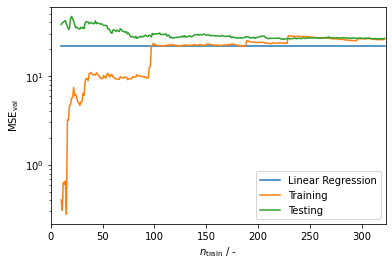

In [19]:
MSE_train = []
MSE_val = []
train_samples = []
Pegasos_linear_CV = Pegasos_regression(regularization=l_best_linear,
                             epoch_max=epoch_max,
                             epsilon=1E-8,
                             verbose=False)

n = X_train.shape[0]
split_fraction = 0.8
n_split = int(n * split_fraction)
X_val_ = X_train[n_split:,:]
y_val_ = y_train[n_split:]

lin_reg_sub = LinearRegression()
lin_reg_sub.fit(X_train[:n_split,:], y_train[:n_split])
y_val = np.dot(X_val_, lin_reg.coef_) + lin_reg.intercept_
MSE_epsilon = Metric_regression().fun_MSE(y_val, y_val_)

n_start = 10
for n_sample in tqdm(range(n_start, n_split)):
    train_samples.append(n_sample)
    X_train_sub = X_train[:n_sample,:]
    y_train_sub = y_train[:n_sample]
    
    Pegasos_linear_CV.fit(X_train_sub, y_train_sub)
    MSE_train.append(Pegasos_linear_CV.MSE(X_train_sub, y_train_sub))
    MSE_val.append(Pegasos_linear_CV.MSE(X_val_, y_val_))
   
plt.plot(train_samples, [MSE_epsilon for n in range(n_start, n_split)])
plt.plot(train_samples, MSE_train)
plt.plot(train_samples, MSE_val)
plt.xlim(0, n_split)
plt.xlabel('$n_\mathrm{{train}}$ / -')
plt.ylabel('MSE$\mathrm{_{val}}$')
plt.legend(['Linear Regression','Training', 'Testing'])
plt.yscale('log')
plt.show()

The Training and testing error are both above the *Linear Regression's*. 
Therefore, the model's capacity is not high enough.
The capacity is increased with the qudratic and kubic kernels resulting in decreasing validaiton errors.